In [197]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [198]:


rhoa = 1  # kg/m3
cp = 1005  # J/kgK
Tz = -15  # air temp
Ts0 = 60  # skin temp
k = 0.4  # Karman constant
sigmas = 7e4  # J/m2K, skin heat capacity

z = 0.01  # hair length, measurement height
zd = z*0.7  # zero plane displacement
z0 = z*0.1  # roughness length

def Ts(uz, t, z=z, zd=zd, z0=z0, sigmas=sigmas, cp=cp, rhoa=rhoa):
    return Tz - (Tz - Ts0)*((z - zd)/z0)**(-(rhoa*cp*uz*k**2)/sigmas*t)

In [199]:
h0 = 0.001  # mm sweat
L = 2257e3   # J/kg, le of vap
p = 101_3000  # Pa, air press
rhow = 997  # kg/m3, dens of water

In [200]:
L*0.05360726*0.622

75256.76638003999

In [201]:
def es(T):
    # Tetens 1930 + Murray 1970 with smooth blending
    water = 610.78*np.exp(17.27*T/(T + 237.3))
    ice = 610.78*np.exp(21.875*T/(T + 265.5))
    svp = 1/2*(water*(np.tanh(20*T) + 1) + ice*(1 - np.tanh(20*T))) 
    return svp

def eps(h):
    # scale evaporation/latent heat exchange to zero when surface water disappears.
    return 0.622*1/2*(np.tanh(50_000*h - 2) + 1)

def rhs(y, t, u=1, T=Tz, sigmas=sigmas, z=z, zd=zd, z0=z0):
    # unpack y into skin temperature and sweat water height
    Ts, h = y

    epsilon = eps(h)
    esat = es(Ts)

    ustar = u*k/np.log((z - zd)/z0)
    coef = rhoa*ustar**2/(sigmas*u)
    H_term = cp*(T - Ts)
    LE_term = -L*epsilon*esat/p
    Tsdot = coef*(H_term + LE_term)
    hdot = -epsilon*rhoa/(p*rhow)*ustar**2/u*esat
    # print(f'eps:{epsilon:.2f}, esat:{esat:.8f}, Ts:{Ts:.2f}, h:{1000*h:.2f}, H:{H_term*coef:.2f}, LE:{LE_term*coef:.2f}, hdot:{hdot*1000:.2f}')
    return (Tsdot, hdot)

In [238]:
y0 = Ts0, h0
t_hans = np.logspace(-3, np.log10(100/6), 10001)
t_franz = np.logspace(-3, np.log10(100/1), 10001)
Ts_hans_wet, h_hans = odeint(rhs, y0, t_hans, args=(6,)).T
Ts_franz_wet, h_franz = odeint(rhs, y0, t_franz, args=(1,)).T

y0 = Ts0, 0
Ts_hans_dry, _ = odeint(rhs, y0, t_hans, args=(6,)).T
Ts_franz_dry, _ = odeint(rhs, y0, t_franz, args=(1,)).T

Text(0, 0.5, 'Skin Temperature (C)')

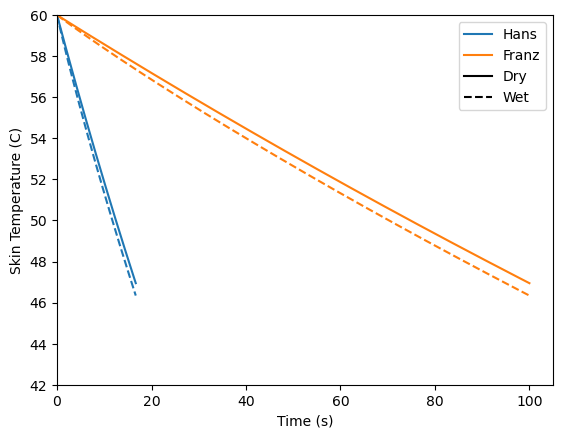

In [237]:
# plt.plot(t_hans, h_hans)
# plt.plot(t_franz, h_franz)


plt.plot(t_hans, Ts_hans_wet, 'C0--')
plt.plot(t_franz, Ts_franz_wet, 'C1--')

plt.plot(t_hans, Ts_hans_dry, 'C0-')
plt.plot(t_franz, Ts_franz_dry, 'C1-')

plt.plot([-30, -30], [-30, -30], 'C0-', label='Hans')
plt.plot([-30, -30], [-30, -30], 'C1-', label='Franz')
plt.plot([-30, -30], [-30, -30], 'k-', label='Dry')
plt.plot([-30, -30], [-30, -30], 'k--', label='Wet')

plt.xlim(0, 105)
plt.ylim(42, 60)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Skin Temperature (C)')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Sweat evaporated (mm)')

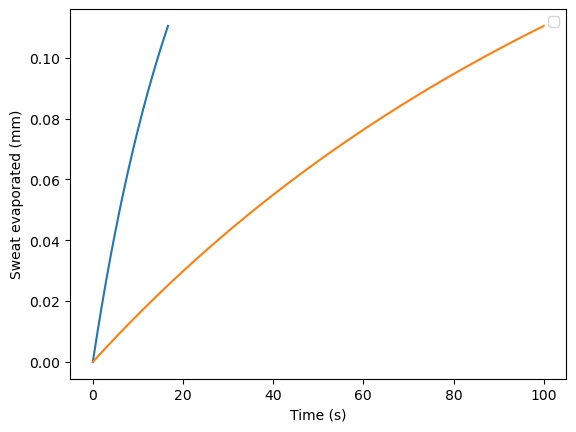

In [241]:
plt.plot(t_hans, 1000*(h0 - h_hans))
plt.plot(t_franz, 1000*(h0 - h_franz))

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Sweat evaporated (mm)')